<a href="https://colab.research.google.com/github/justbautista/hackNJITproject/blob/main/Model/Chest_XRAY.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In this Colab Notebook, we import the chest X ray dataset from kaggle and train a neural network to detect whether or not an xray image has pneumonia or if it is healthy.

In [1]:
!mkdir .kaggle
!ls

sample_data


In [2]:
import json
token = {"username":"dazzykin","key":"8e623a44cc7443bae9c0b42ca5d093c8"}
with open('/content/.kaggle/kaggle.json', 'w') as file:
    json.dump(token, file)

In [4]:
!cp /content/.kaggle/kaggle.json ~/.kaggle/kaggle.json
!kaggle config set -n path -v{/content}


- path is now set to: {/content}


In [5]:
!chmod 600 /root/.kaggle/kaggle.json

In [6]:
!kaggle datasets download -d paultimothymooney/chest-xray-pneumonia

100% 2.29G/2.29G [00:30<00:00, 45.3MB/s]
100% 2.29G/2.29G [00:30<00:00, 81.3MB/s]


In [7]:
%cd {/content}/datasets/paultimothymooney/chest-xray-pneumonia

/content/{/content}/datasets/paultimothymooney/chest-xray-pneumonia


In [8]:
%pwd

'/content/{/content}/datasets/paultimothymooney/chest-xray-pneumonia'

In [ ]:
!unzip \*.zip

In [10]:
#Import Keras Libraries
import os
import os.path
from PIL import Image
from PIL import ImageFilter
import numpy as np
import keras
import pandas as pd
from keras.models import Sequential,Model,load_model
from keras.layers import Conv2D, MaxPooling2D,GlobalAveragePooling2D, AveragePooling2D
from keras.layers import Dense,Flatten, Dropout, Activation
import sys
from keras.layers import Input
from keras.preprocessing.image import ImageDataGenerator
from keras.applications.inception_resnet_v2 import InceptionResNetV2
from keras import applications


Our classifier will 

In [11]:
#Declare our variables
num_classes=  2
nb_channels = 3
target_height = 224
target_width = 224
batch_size = 32
x_train="chest_xray/train/"
x_test = "chest_xray/test/"

In [12]:
train_datagen = ImageDataGenerator(rescale=1./255,shear_range=0.2,zoom_range=0.2,horizontal_flip=True)
training_set = train_datagen.flow_from_directory(x_train,target_size=(target_height,target_width),batch_size=batch_size,class_mode='categorical')

Found 5216 images belonging to 2 classes.


In [23]:
x_batch, y_batch = next(training_set)

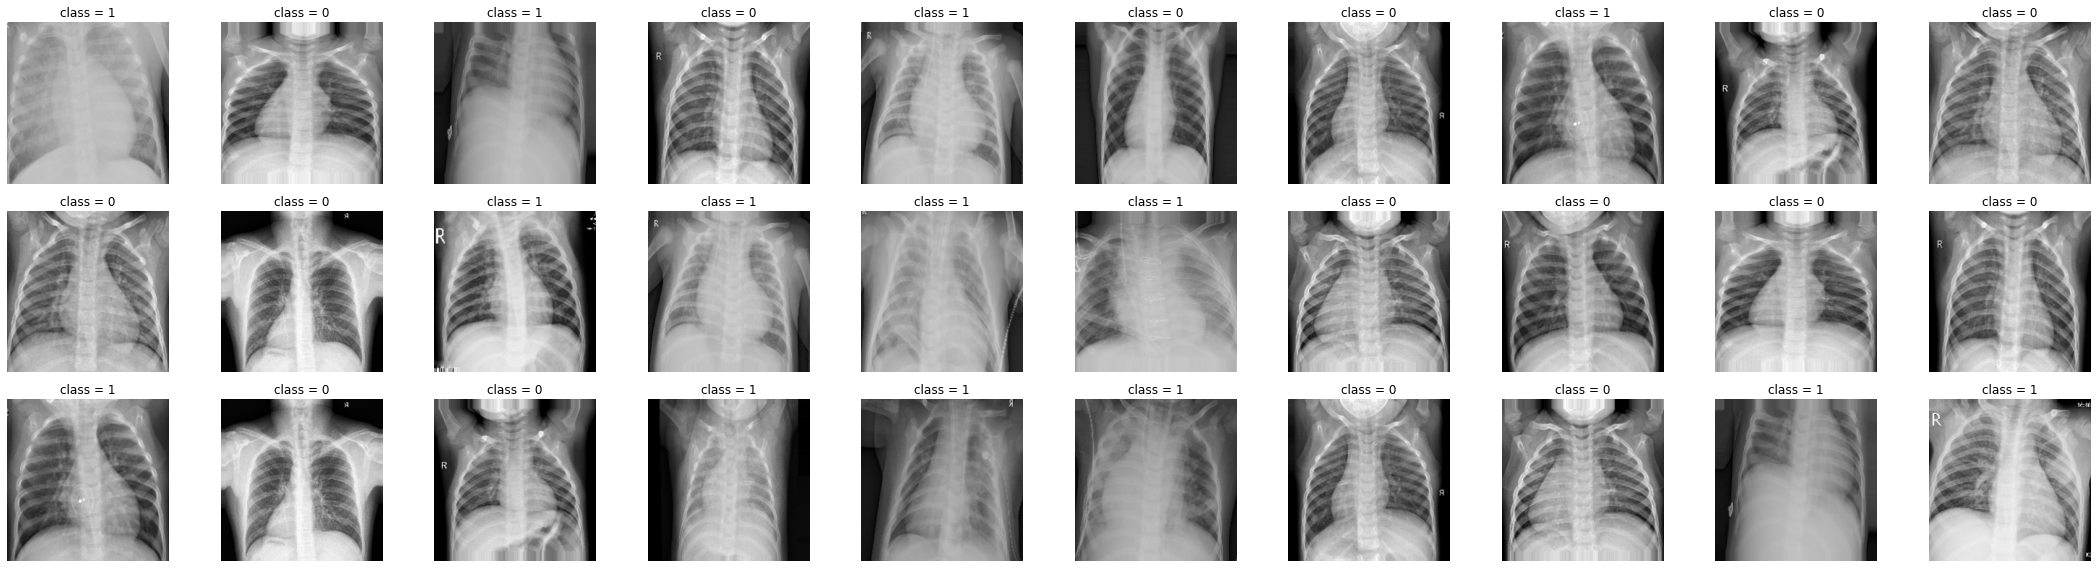

In [28]:
import matplotlib.pyplot as plt
n_imgs = 30
n_rows = int(n_imgs//10)
fig, ax = plt.subplots(n_rows,10, figsize = (30,8))


for i in range(n_imgs):
  idx = np.random.randint(0,x_batch.shape[0])
  ax.flat[i].imshow(x_batch[idx,...])
  ax.flat[i].set_title("class = %i"%np.where(y_batch[idx] == 1)[0][0])
  ax.flat[i].axis('off')

fig.tight_layout()

In [13]:
my_model = applications.vgg16.VGG16(weights='imagenet', include_top=False, input_shape= (target_height,target_width,nb_channels))


58892288/58889256 [==============================] - 1s 0us/step


In [14]:
for layer in my_model.layers:
    layer.trainable=False

In [15]:
x = my_model.output
x = Flatten()(x)

In [16]:
c = Dense(num_classes, activation='softmax')(x)
model = Model(inputs = my_model.input, outputs = c)
opt = keras.optimizers.Adam(lr=0.001, decay=1e-7)
model.compile(optimizer = opt, loss = 'categorical_crossentropy', metrics = ['accuracy'])

In [17]:
model.fit_generator(training_set,steps_per_epoch=300,epochs=3)

Instructions for updating:
Please use Model.fit, which supports generators.
Epoch 1/3
163/300 [===============>..............] - 101s 620ms/step - loss: 0.1552 - accuracy: 0.9381


In [18]:
val_datagen = ImageDataGenerator(rescale=1./255)
val_set = val_datagen.flow_from_directory(x_test,target_size=(224,224),batch_size=32,class_mode='categorical')

Found 624 images belonging to 2 classes.


In [19]:
scores = model.evaluate(val_set)
print("Accuracy = ", round(scores[1],2))
print("test error",round(1-scores[1],2))

20/20 [==============================] - 6s 315ms/step - loss: 0.2928 - accuracy: 0.9022
Accuracy =  0.9
test error 0.1


#Save the model

In [20]:
model.save("pneum.h5")